# "Imputation"

Goal is as follows:

Moving to irregular grid
For each initial condition (and from REAL SOLUTION)
 - arbitrary # of time points (big enough)
 - arbitrary spacing between them
 - sample section @ those time points
     - https://stackoverflow.com/questions/6482889/get-random-sample-from-list-while-maintaining-ordering-of-items
 - fit a polynomial (cubic spline)
 - sample from the fit on a regular grid
 - Run SINDy on regular grid fit
 - test the solution MSE (SINDy - real)
 - MSE (polynomial values - real) as an extra
 
 ### 7/13
    Have sampled 75% of tvals at random spacing while preserving order in ONE trajectory using stackoverflow code. Need to apply to multiple trajectories. Same # of time points and spacing for all trajectories or no? 

    Maybe just wrap the code into a for loop of n_of_ic and conglomerate? But then need to resolve difference in length. That's what the polynomial is for? Build poly from sampled points and then use it to "put back" points onto our structure?
    
    NEXT STEP, look into fitting poly w/ cubic spline

 ### 7/14
    Had worries that I'd have trouble getting points outside of our sample time range (i.e. sampled points start at `t=2` and we want to guess t=0 but spline only accounts for max(t)>t>2. Calling the constructed cubicspline method on something slightly outside seems to work though.
    End of the day, I also implemented it for multiple trajectories and had it in a 'stack' structure similar to the true data set so that `model.fit()` could operate on it.
    
 ### 7/15
     Made SINDy model from cubicspline imputed set. Came out with higher error than the cubicspline... Also found that Radau method of integration takes much longer than LSODA and BDF methods. SINDy error increases more when timestep # is decreased. With `n_of_t=5000`, error is low but still larger than cubic spline.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
#import colorednoise as cn
import random
from scipy.interpolate import CubicSpline

In [23]:
# test cell
len(netswitch_train_multi[0][:, 0])
sample_size
range(len(first_traj[:, 0]))
mylist = [ 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 ,9  , 10 ]
indices = random.sample(range(len(mylist)), 3)
[mylist[i] for i in sorted(indices)]

[first_traj[i, :] for i in sorted(random.sample(range(len(first_traj[:, 0])), 3000)) ]
(np.random.randint(int(0.5 * n_of_t), n_of_t + 1))
rng = np.random.default_rng()
rng.integers(low=int(0.25 * n_of_t), high=n_of_t)
# error in line below because netswitch_train_multi is a list so I have to access it like [i][:, 0]
#etswitch_train_multi[1, :, 0]

TypeError: list indices must be integers or slices, not tuple

In [2]:
# contains functions + basic parameters
a_u, a_v = 2, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a_u / (1+v**beta))
dvdt = lambda u, v: -v + (a_v / (1+u**gamma))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.8, 10)
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
# 0-5 minus some value between 0-1, no negatives for IC?
n_of_ic = 1000
u_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)
v_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)

def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["u", "v"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [3]:
# creation of TRUE set
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
n_of_t = 5000
tvals = np.linspace(0, T, n_of_t)
n_of_ic = 500
feature_count = 2
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5)
sparse_regression_optimizer = ps.STLSQ(threshold=0.3)
MSE_list = []
netswitch_train_multi = []
integrator_keywords = {}
#integrator_keywords['full_output'] = True
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# actual creation
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(min(netswitch_x0s[:,0]))
print(min(netswitch_x0s[:,1]))

{'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}
0.0037493429521123778
0.0016683899516911627


(5000,)
(3, 2)
[0.60000117 1.84123864 1.87817951]

3
3
5000


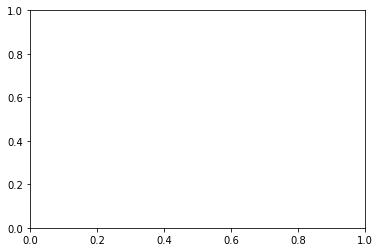

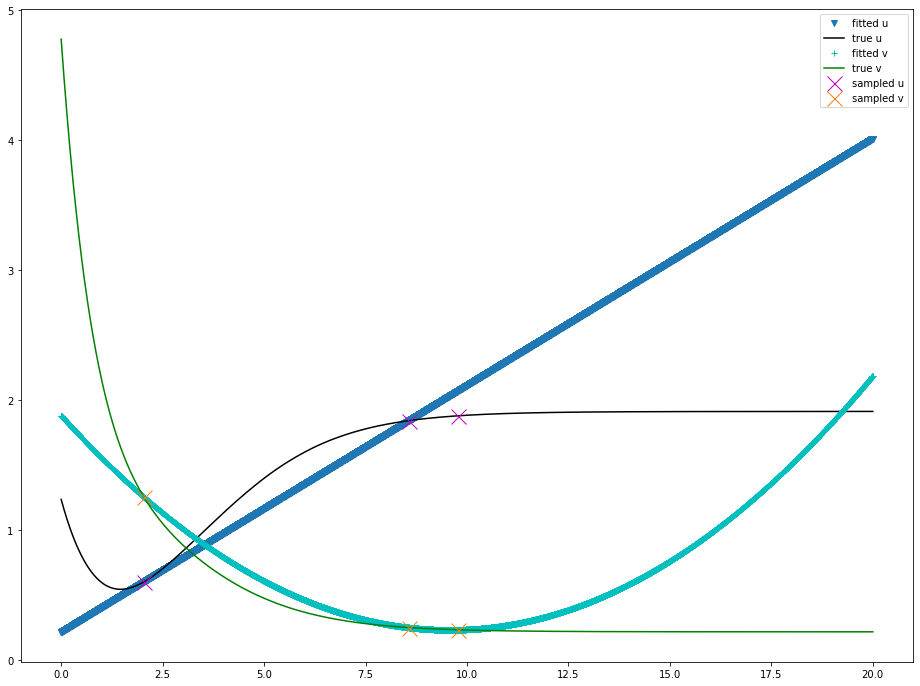

In [91]:

## one trajectory
rng = np.random.default_rng()
first_traj = netswitch_train_multi[0]


sample_size = 3#rng.integers(low=int(0.25 * n_of_t), high=int(0.75 * n_of_t))

indices = sorted(
    random.sample(range(len(first_traj[:, 0])), int(sample_size)))
sorted_sample = np.asarray([
    first_traj[j, :] for j in indices
])

# fit to corresponding time values and not the indices
cs_u = CubicSpline(tvals[indices[0:2]], sorted_sample[0:2, 0])
cs_v = CubicSpline(tvals[indices], sorted_sample[:, 1])

 # for testing one trajectory

fig, axs = plt.subplots()
plt.figure(figsize=(16, 12))
plt.plot(tvals, cs_u(tvals), "v", label="fitted u")
plt.plot(tvals, first_traj[:,0], 'k', label="true u")
plt.plot(tvals, cs_v(tvals), "c+", label="fitted v")
plt.plot(tvals, first_traj[:, 1], 'g', label="true v")
plt.plot(tvals[indices], sorted_sample[:, 0],"mx",label="sampled u", markersize=15)
plt.plot(tvals[indices], sorted_sample[:, 1], "x",label="sampled v", markersize=15)

plt.legend()

print(tvals.shape)
print(sorted_sample.shape)
print(sorted_sample[0:3, 0])
print(CubicSpline(tvals[indices[0:2]], sorted_sample[0:2, 0]))

print()

print(len(indices))
print(len(sorted_sample[:,0]))
print(len(tvals))

[[1.33816411e+00 4.91530858e+00]
 [1.87185789e+00 1.11940009e+00]
 [2.01595499e+00 1.26571589e+00]
 [1.63979692e+00 2.81059623e+00]
 [6.89644648e-01 4.26969425e+00]
 [2.62116703e+00 4.95518327e+00]
 [8.56949213e-01 4.18861468e-01]
 [3.08374043e+00 3.42439751e+00]
 [3.52762846e+00 3.14782994e+00]
 [2.86091937e-01 4.70969330e+00]
 [1.09699942e+00 4.04372201e-01]
 [1.87848524e+00 8.82544727e-02]
 [7.20920296e-01 6.24549839e-01]
 [5.41418137e-02 3.95359756e+00]
 [4.23439399e-01 3.88751618e+00]
 [3.96181873e+00 1.58993866e+00]
 [3.33008165e+00 4.76364203e+00]
 [2.53565988e+00 4.86957583e+00]
 [4.99171221e+00 2.31264338e-01]
 [3.44032617e+00 2.75870330e+00]
 [2.38411665e+00 4.04760001e+00]
 [4.04006043e+00 3.50773764e+00]
 [3.37786042e+00 1.46259302e+00]
 [1.74029046e+00 4.35796435e+00]
 [3.07149680e+00 1.49266400e-01]
 [4.42757583e+00 2.00181154e-01]
 [3.38779904e+00 4.85315446e+00]
 [3.75226360e+00 1.78410411e+00]
 [1.14778725e+00 2.07913965e+00]
 [3.29913169e+00 1.81344184e+00]
 [4.753786

(u)' = -0.400 u + 0.801 1/(1 + v^2)
(v)' = -0.400 v + 0.400 1/(1 + u^2)
65.49723679625914
5.7911688715619324e-12


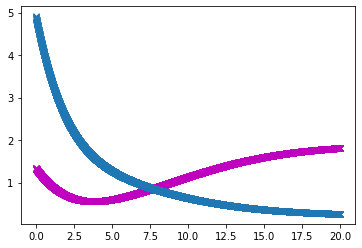

In [36]:
rng = np.random.default_rng()
first_traj = netswitch_train_multi[0]
netswitch_fitted_multi = []
# Takes a random sample of values from the strue solution to emulate missingess
# and then uses fits it as cubic spline
print(netswitch_x0s)
for i in range(n_of_ic):
    sample_size = rng.integers(low=int(0.25 * n_of_t), high=int(0.75 * n_of_t))

    indices = sorted(
        random.sample(range(len(netswitch_train_multi[i][:, 0])), int(sample_size)))
    sorted_sample = np.asarray([
        netswitch_train_multi[i][j, :] for j in indices
    ])

    # fit to corresponding time values and not the indices
    cs_u = CubicSpline(tvals[indices], sorted_sample[:, 0])
    cs_v = CubicSpline(tvals[indices], sorted_sample[:, 1])
    fitted_sheet = np.array([cs_u(tvals), cs_v(tvals)]).T
    netswitch_fitted_multi.append(fitted_sheet)

model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
model.fit(netswitch_fitted_multi, t=dt, multiple_trajectories=True)
model.print()

# create simulations list to hold simulated data for corresponding IC
simulations = []
for k in range(n_of_ic):
    # problem area with warnings
    netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint", integrator_kws=integrator_keywords)
    simulations.append(netswitch_sim)
MSE_SINDy_real = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
MSE_poly_real = np.square(np.subtract(netswitch_train_multi, netswitch_fitted_multi)).sum() / (len(tvals) * feature_count * n_of_ic)
print(MSE_SINDy_real)
print(MSE_poly_real)
plt.plot(tvals, simulations[0][:, 0],"mx",label="sampled u")
plt.plot(tvals, simulations[0][:, 1], "x",label="sampled v")

In [41]:
print(tvals[1]-tvals[0])
print(len(tvals))
print(tvals)

0.004000800160032006
5000
[0.00000000e+00 4.00080016e-03 8.00160032e-03 ... 1.99919984e+01
 1.99959992e+01 2.00000000e+01]
